In [225]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.datasets import make_classification

from sklearn import cross_validation
from sklearn.metrics import accuracy_score,f1_score
import math

In [106]:
import warnings; warnings.simplefilter('ignore')

## Applying randomized optimization algorithms to a Multi-layer perceptron

### Cosntruct the MLP class with 1 hidden layer which has following parameters and methods
* Hidden layer size i.e. number of neurons
* Choice of the optimization method for gradient based methods
* Maximum number of iterations
* **`Fit()`** method for gradient (Jacobian) and 2nd-derivative (Hessian) based optimization techniques
* **`Fit_simplex()`** method for optimization through simple downhill descent (***derivative-free***)
* **`Fit_anneal()`** method to implement simulated annealing (***derivative-free***)

In [392]:
class NN_1HL(object):

    def __init__(self, reg_lambda=0, epsilon_init=0.12, hidden_layer_size=25, opti_method='TNC', maxiter=500):
        self.reg_lambda = reg_lambda
        self.epsilon_init = epsilon_init
        self.hidden_layer_size = hidden_layer_size
        self.activation_func = self.sigmoid
        self.activation_func_prime = self.sigmoid_prime
        self.method = opti_method
        self.maxiter = maxiter

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_prime(self, z):
        sig = self.sigmoid(z)
        return sig * (1 - sig)

    def sumsqr(self, a):
        return np.sum(a ** 2)

    def rand_init(self, l_in, l_out):
        self.epsilon_init = (math.sqrt(6))/(math.sqrt(l_in + l_out))
        return np.random.rand(l_out, l_in + 1) * 2 * self.epsilon_init - self.epsilon_init

    def pack_thetas(self, t1, t2):
        return np.concatenate((t1.reshape(-1), t2.reshape(-1)))

    def unpack_thetas(self, thetas, input_layer_size, hidden_layer_size, num_labels):
        t1_start = 0
        t1_end = hidden_layer_size * (input_layer_size + 1)
        t1 = thetas[t1_start:t1_end].reshape((hidden_layer_size, input_layer_size + 1))
        t2 = thetas[t1_end:].reshape((num_labels, hidden_layer_size + 1))
        return t1, t2

    def _forward(self, X, t1, t2):
        m = X.shape[0]
        ones = None
        if len(X.shape) == 1:
            ones = np.array(1).reshape(1,)
        else:
            ones = np.ones(m).reshape(m,1)

        # Input layer
        a1 = np.hstack((ones, X))

        # Hidden Layer
        z2 = np.dot(t1, a1.T)
        a2 = self.activation_func(z2)
        a2 = np.hstack((ones, a2.T))

        # Output layer
        z3 = np.dot(t2, a2.T)
        a3 = self.activation_func(z3)
        return a1, z2, a2, z3, a3

    def function(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y, reg_lambda):
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)

        m = X.shape[0]
        Y = np.eye(num_labels)[y]

        _, _, _, _, h = self._forward(X, t1, t2)
        costPositive = -Y * np.log(h).T
        costNegative = (1 - Y) * np.log(1 - h).T
        cost = costPositive - costNegative
        J = np.sum(cost) / m

        if reg_lambda != 0:
            t1f = t1[:, 1:]
            t2f = t2[:, 1:]
            reg = (self.reg_lambda / (2 * m)) * (self.sumsqr(t1f) + self.sumsqr(t2f))
            J = J + reg
        return J

    def function_prime(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y, reg_lambda):
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)

        m = X.shape[0]
        t1f = t1[:, 1:]
        t2f = t2[:, 1:]
        Y = np.eye(num_labels)[y]

        Delta1, Delta2 = 0, 0
        for i, row in enumerate(X):
            a1, z2, a2, z3, a3 = self._forward(row, t1, t2)

            # Backprop
            d3 = a3 - Y[i, :].T
            d2 = np.dot(t2f.T, d3) * self.activation_func_prime(z2)

            Delta2 += np.dot(d3[np.newaxis].T, a2[np.newaxis])
            Delta1 += np.dot(d2[np.newaxis].T, a1[np.newaxis])

        Theta1_grad = (1 / m) * Delta1
        Theta2_grad = (1 / m) * Delta2

        if reg_lambda != 0:
            Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (reg_lambda / m) * t1f
            Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (reg_lambda / m) * t2f

        return self.pack_thetas(Theta1_grad, Theta2_grad)

    def fit(self, X, y):
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        _res = optimize.minimize(self.function, thetas0, jac=self.function_prime, method=self.method, 
                                 args=(input_layer_size, self.hidden_layer_size, num_labels, X, y, 0), 
                                 options=options)
        
        #print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
    def fit_simplex(self, X, y):
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        _res = optimize.fmin(self.function, thetas0, maxiter=self.maxiter,disp=False,
                            args=(input_layer_size, self.hidden_layer_size, num_labels, X, y, 0))
        
        _res=np.array(_res)
        #print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
    def fit_anneal(self, X, y,temp=None):
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        
        if temp!=None:
            model_T=temp
        
        _res = optimize.basinhopping(self.function, thetas0, niter=self.maxiter,T=model_T,
                                    minimizer_kwargs={'args':(input_layer_size, self.hidden_layer_size, 
                                                              num_labels, X, y, 0)})
        
        #print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")

    def predict(self, X):
        return self.predict_proba(X).argmax(0)

    def predict_proba(self, X):
        _, _, _, _, h = self._forward(X, self.t1, self.t2)
        return h

### For test - create some synthetic data

In [217]:
data = make_classification(n_samples=200,n_features=4,n_informative=4,
                           n_classes=2,n_redundant=0,class_sep=0.5,flip_y=0.2)

In [220]:
features=data[0]
response=data[1]
full_data=np.column_stack((features,response))

In [222]:
df=pd.DataFrame(full_data,columns=['X'+str(i) for i in range(4)]+['y'])

In [223]:
df.head()

,X0,X1,X2,X3,y
0,0.551892,1.682256,1.951063,-0.524038,1.0
1,0.990574,0.915692,0.925077,0.393715,1.0
2,0.955246,-0.512989,0.843275,-0.611411,0.0
3,0.919453,0.216391,-1.106692,-0.627984,0.0
4,0.990075,1.867310,-0.554116,1.484783,1.0


### Visualize

We plot histograms, boxlots and scatterplots of the dataset and observe that the **class separation is not very obvious**. Particularly, boxplots show lot of overlap between features for two output classes.

So, this should be a **non-trivial classification task.**

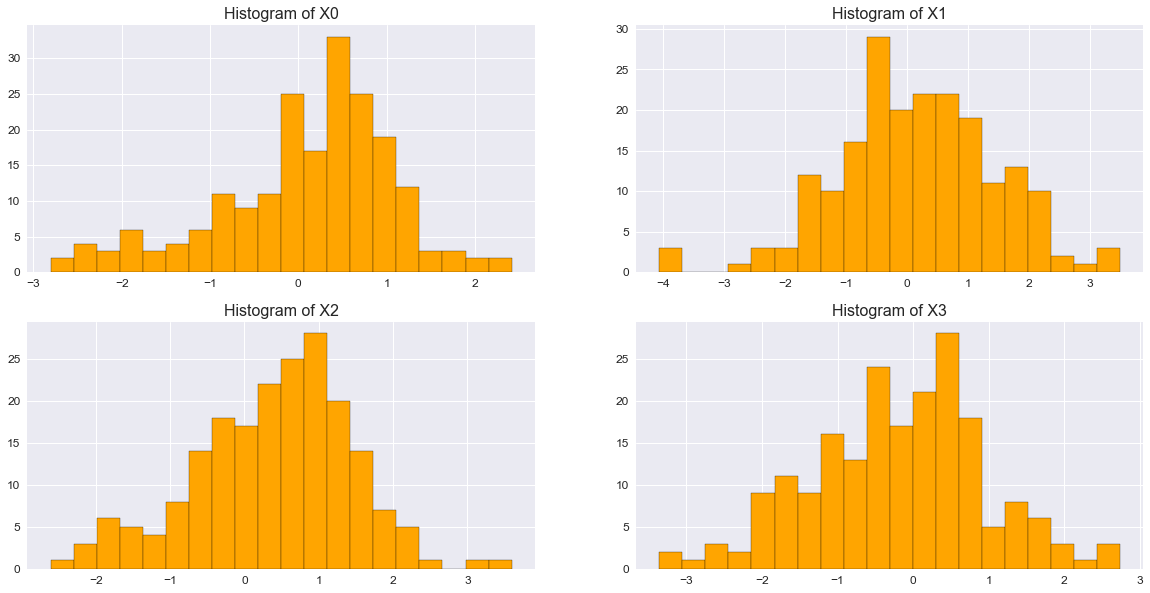

In [226]:
i=1
plt.figure(figsize=(20,10))
for c in df.describe().columns[:-1]:
    plt.subplot(2,2,i)
    plt.title(f"Histogram of {c}",fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.hist(df[c],bins=20,color='orange',edgecolor='k')
    i+=1
plt.show()

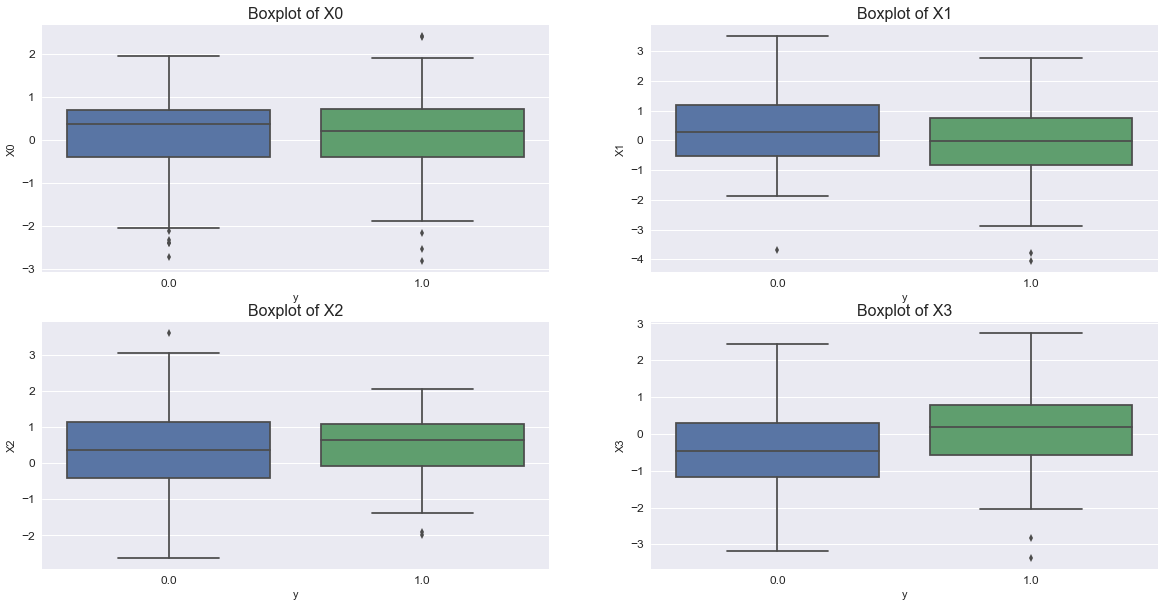

In [227]:
i=1
plt.figure(figsize=(20,10))
for c in df.columns[:-1]:
    plt.subplot(2,2,i)
    plt.title(f"Boxplot of {c}",fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    sns.boxplot(y=df[c],x=df['y'])
    i+=1
plt.show()

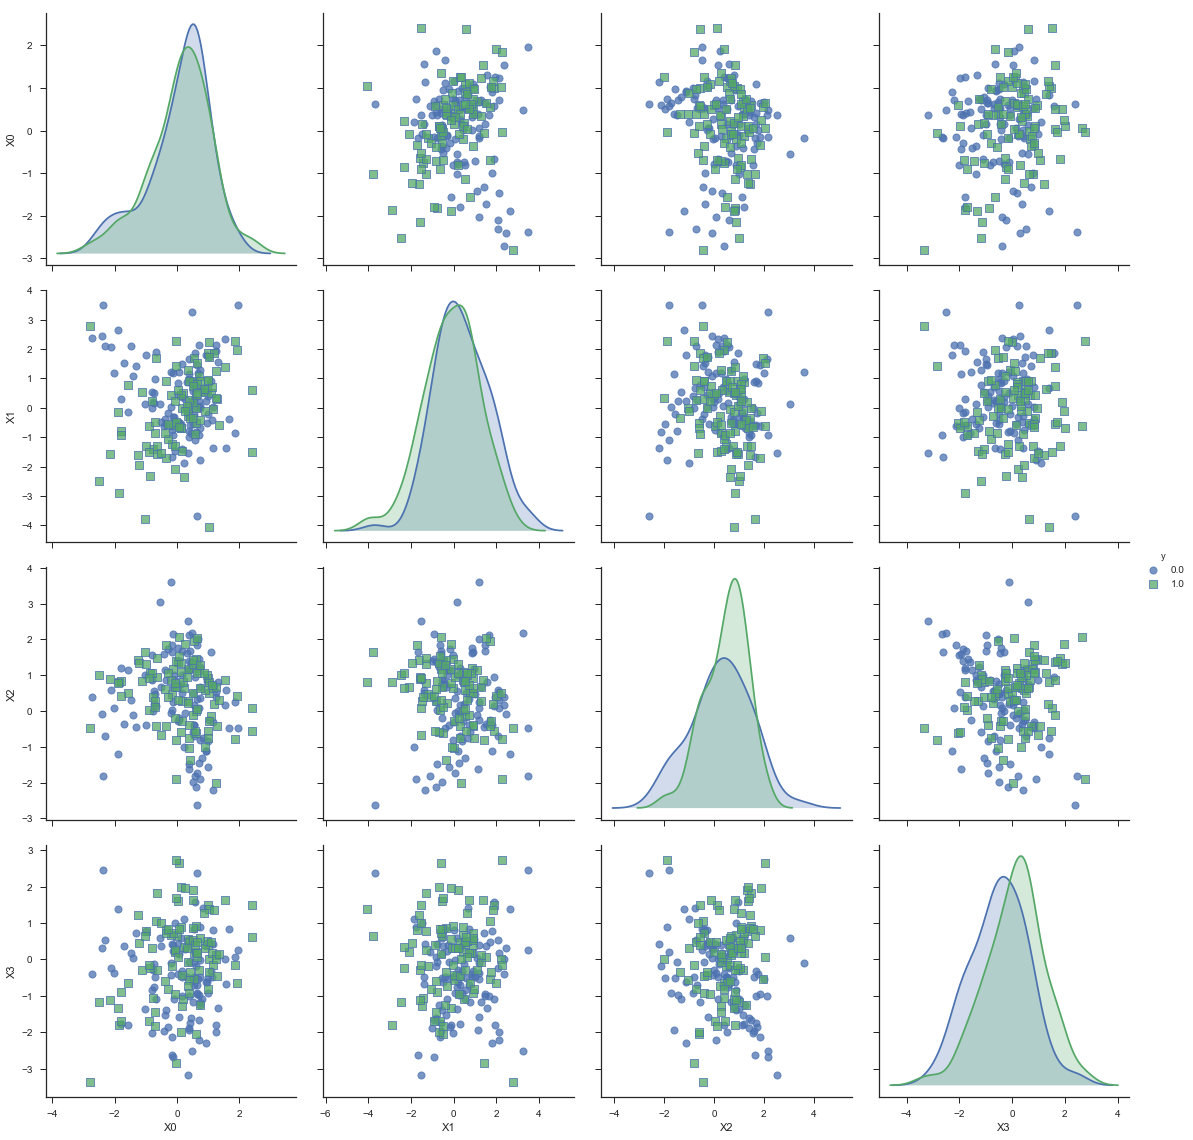

In [237]:
sns.set(style="ticks", color_codes=True)
g=sns.pairplot(df,vars=['X0','X1','X2','X3'],
               plot_kws=dict(s=50, edgecolor="b", linewidth=1,alpha=0.75),
               hue="y",markers=["o", "s"], diag_kind="kde",diag_kws=dict(shade=True), size=4)

### Save the data in a text file

In [238]:
np.savetxt('scipy_test.txt',X=full_data,delimiter=', ')

### Read the data from the file

In [239]:
values = np.loadtxt('scipy_test.txt', delimiter=', ', usecols=[0,1,2,3])
targets = np.loadtxt('scipy_test.txt', delimiter=', ', dtype=(int), usecols=[4])

### Train/test split

In [240]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(values, targets, test_size=0.4)

### Fit with the random hill climb (descent) method and show accuracy and F1 score

In [393]:
nn = NN_1HL(hidden_layer_size=5,maxiter=50000)
nn.fit_simplex(values, targets)
print("Accuracy of classification: "+str(accuracy_score(y_test, nn.predict(X_test))))
print("F1 score of classification: "+str(f1_score(y_test, nn.predict(X_test))))

Accuracy of classification: 0.75
Accuracy of classification: 0.7500000000000001


### Fit with simulated annealing and show accuracy and F1 score

In [303]:
nn = NN_1HL(hidden_layer_size=5,maxiter=50)
nn.fit_anneal(values, targets,temp=100)
print("Accuracy of classification: "+str(accuracy_score(y_test, nn.predict(X_test))))
print("F1 score of classification: "+str(f1_score(y_test, nn.predict(X_test))))

Accuracy of classification: 0.8375
Accuracy of classification: 0.821917808219178


### Try various optimization rotuines from `scipy.optimize()`

In [394]:
solvers=['BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

In [395]:
for s in solvers:
    nn = NN_1HL(opti_method=s,maxiter=10000)
    nn.fit(values, targets)
    print(f"Accuracy of classification: using {s}: "+str(accuracy_score(y_test, nn.predict(X_test))))
    print(f"F1-score of classification: using {s}: "+str(f1_score(y_test, nn.predict(X_test))))
    print("="*80)

Accuracy of classification: using BFGS: 0.9375
F1-score of classification: using BFGS: 0.9397590361445782
Accuracy of classification: using L-BFGS-B: 1.0
F1-score of classification: using L-BFGS-B: 1.0
Accuracy of classification: using TNC: 0.9125
F1-score of classification: using TNC: 0.9113924050632912
Accuracy of classification: using COBYLA: 0.8125
F1-score of classification: using COBYLA: 0.8148148148148148
Accuracy of classification: using SLSQP: 0.9875
F1-score of classification: using SLSQP: 0.9879518072289156
